# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Read Data and Process

In [2]:
seeds = np.array([85744, 39350, 62007, 27231, 17228, 23170, 28217, 21995, 92637, 33582, 82945, 97198, 21490, 65985, 13704,
                  51186, 92608, 19003, 57905, 71554, 13601, 22752, 83194, 63649, 52799, 33528, 18501, 99162, 93396, 12349,
                  39975, 94940, 66026, 99507, 87312, 10869, 76079, 87705, 42204, 82733, 24992, 60546, 32898, 87808, 68099,
                  82185, 49493, 33261, 59667, 54386, 69836, 36964, 62281, 78712, 61596, 45089, 66142, 92100, 95047, 18342,
                  97134, 76054, 59190, 16956, 52012, 97448, 72537, 74642, 64659, 74339, 89717, 90645, 55079, 84367, 59699,
                  46207, 20271, 17741, 29556, 59305, 83988, 97163, 44867, 64963, 36372, 34887, 66534, 27667, 11008, 60419,
                  60361, 72188, 53605, 96824, 33170, 23939, 69498, 71559, 15470, 58697])

In [3]:
def getReason(seed, path):
    seedIdx = np.where(seeds == int(seed))[0][0]
    pattern = path+"error_" + str(seedIdx) + ".err"
    timeString = "DUE TO TIME LIMIT ***"
    memString = "OOM Killed."
    try:
        filePath = glob.glob(pattern)[0]
    except:
        print("No error file")
        return
    
    with open(filePath, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    
    if timeString in content:
        print(seed, "stopped due to time limit")
    elif memString in content:
        print(seed, "stopped due to mem limit")
    else:
        print("Non-time or mem issue")

In [4]:
def getIndividualRACaptRate(seed, path):
    filePath = path + seed + "/output" + seed + ".csv"
    captRates = []

    eof = False
    with open(filePath, 'r', encoding='utf-8', errors='ignore') as f:
        while not eof:
            line = f.readline()
            
            if not line:
                eof = True
                continue

            if line[0] == "-":
                if "Mean Aitchison" in line:
                    captRates.append(float(f.readline().partition(":")[2]))
    return captRates

In [5]:
def readInData(root, totalCoeffPerSeed = 550):
    # Get all the folders in the root and drop the code folders
    directories = [s for s in os.listdir(root) if os.path.isdir(root+s)]

    # Initating the dataframe, some folders may not have RAStats<seed>.csv due to memory or time-out
    dataInitated = False
    startIdx = 0
    indRACaptRates = pd.DataFrame(index=seeds, columns=["MeAD"])
    while not dataInitated:
        dataInitated = True
        try:
            indRACaptRates.loc[int(directories[startIdx])] = getIndividualRACaptRate(directories[startIdx], root)
            RAData = pd.read_csv(os.path.join(root, directories[startIdx], "RAStats"+directories[startIdx]+".csv"), usecols=range(8))
            if directories[startIdx] == "92608":
                print(RAData)
            RAData['seed'] = directories[startIdx]
            if RAData.shape[0] < totalCoeffPerSeed:
                print(directories[startIdx], "processed", RAData.shape[0], "coefficients")
                getReason(directories[startIdx])
        except:
            print(directories[startIdx], " did not have RA stats")
            dataInitated = False
        startIdx += 1

    # Appending all the rest of the RAStats<seed>.csv to the initial RAStats<seed>.csv
    for i in range(startIdx, len(directories)):
        try:
            indRACaptRates.loc[int(directories[i])] = getIndividualRACaptRate(directories[i], root)
            toAppend = pd.read_csv(os.path.join(root, directories[i], "RAStats"+directories[i]+".csv"), usecols=range(8))
            toAppend['seed'] = directories[i]
            if toAppend.shape[0] < totalCoeffPerSeed:
                print(directories[i], "processed", toAppend.shape[0], "coefficients")
                getReason(directories[i], root) 
            if toAppend.shape[0] != 0:
                RAData = pd.concat([RAData, toAppend])
        except:
            print(directories[i], " did not have RA stats")
            getReason(directories[i], root)
    
    RAData = RAData.set_index(['category','seed'])
     
    return RAData, indRACaptRates

In [6]:
# used for multiple covatiates models
def getResults(dat, resDat, col, rowName):
    indx = list(range(5, 51))
    toAdd = dat.loc[[1,2,3,4], col].describe().loc[["mean", "50%"]]
    toAdd = pd.concat([toAdd, dat.loc[indx, col].describe().loc[["mean", "50%"]]], ignore_index=True)
    toAdd = toAdd.to_frame().T
    toAdd.columns = ["Mean " + col + " Cat 1-4", "Median " + col + " Cat 1-4", "Mean " + col + " Cat 5-50", "Median " + col + " Cat 5-50"]
    toAdd.index = [rowName]
    if resDat is None:
        resDat = toAdd
    else:
        resDat = pd.concat([resDat, toAdd])
    return resDat

# Alternative Model Comparison

In [7]:
RAData, indRACaptRates = readInData("FunCZIDM50/", totalCoeffPerSeed = 550)

In [8]:
RAData.columns = RAData.columns.str.strip()

In [9]:
toDrop = np.unique(RAData[RAData["mean RMSE"] > 1e+02].index.get_level_values(1))
toKeep = RAData.index.levels[1].difference(toDrop)
RAData = RAData.loc[(slice(None), toKeep), :]

In [10]:
RADataIntercept = RAData[RAData["covariate"] == "intercept"]
RADataCov = RAData[RAData["covariate"] != "intercept"]

In [11]:
RAEval = getResults(RADataCov, None, "RA 95 CI", "Covariates")
RAEval = getResults(RADataIntercept, RAEval, "RA 95 CI", "Intercepts")
BEval = getResults(RADataCov, None, "B(t) 95 CI", "Covariates")
BEval = getResults(RADataIntercept, BEval, "B(t) 95 CI", "Intercepts")
RMSEEval = getResults(RADataCov, None, "mean RMSE", "Covariates")
RMSEEval = getResults(RADataIntercept, RMSEEval, "mean RMSE", "Intercepts")
IndRAEval = pd.DataFrame(indRACaptRates.mean()).T
IndRAEval.index = ["FunCZIDM"]

In [12]:
toDrop

array([], dtype=object)

In [13]:
RAData["mean RMSE"].sort_values()

category  seed 
39        53605    0.001211
37        36964    0.001281
23        94940    0.001286
10        52012    0.001293
27        32898    0.001308
                     ...   
4         33528    0.725972
50        60546    0.846329
2         90645    1.277488
4         36964    1.343703
2         74642    2.538248
Name: mean RMSE, Length: 55000, dtype: float64

In [14]:
window = 750
std = (window - 1)/6
metrics = ["RA 95 CI", "B(t) 95 CI", "mean RMSE"]
plotDat = RADataCov.loc[[1,2,3,4], ["zero prop"]+metrics].sort_values("zero prop")
x = plotDat["zero prop"]
y = plotDat[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)

In [15]:
RAData, indRACaptRates = readInData("DM50/", totalCoeffPerSeed = 550)

In [16]:
RAData.columns = RAData.columns.str.strip()

In [17]:
toDrop = np.unique(RAData[RAData["mean RMSE"] > 1e+02].index.get_level_values(1))
toKeep = RAData.index.levels[1].difference(toDrop)
RAData = RAData.loc[(slice(None), toKeep), :]

In [18]:
toDrop

array([], dtype=object)

In [19]:
RAData["mean RMSE"].sort_values()

category  seed 
20        57905    0.000857
18        97163    0.000857
32        74339    0.000881
28        29556    0.000890
10        12349    0.000902
                     ...   
4         82945    0.722954
1         92637    0.736550
4         72537    0.862002
2         76079    0.914151
          21490    1.685683
Name: mean RMSE, Length: 55000, dtype: float64

In [20]:
RADataIntercept = RAData[RAData["covariate"] == "intercept"]
RADataCov = RAData[RAData["covariate"] != "intercept"]

In [21]:
RAEval = getResults(RADataCov, RAEval, "RA 95 CI", "DM Covariates")
RAEval = getResults(RADataIntercept, RAEval, "RA 95 CI", "DM Intercepts")
BEval = getResults(RADataCov, BEval, "B(t) 95 CI", "DM Covariates")
BEval = getResults(RADataIntercept, BEval, "B(t) 95 CI", "DM Intercepts")
RMSEEval = getResults(RADataCov, RMSEEval, "mean RMSE", "DM Covariates")
RMSEEval = getResults(RADataIntercept, RMSEEval, "mean RMSE", "DM Intercepts")
toAdd = pd.DataFrame(indRACaptRates.mean()).T
toAdd.index = ["DM"]
IndRAEval = pd.concat([IndRAEval, toAdd])

In [22]:
plotDat = RADataCov.loc[[1,2,3,4], ["zero prop"]+metrics].sort_values("zero prop")
x_DM = plotDat["zero prop"]
y_DM = plotDat[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)

In [23]:
RAData, indRACaptRates = readInData("FunCDM50/", totalCoeffPerSeed = 550)

In [24]:
RAData.columns = RAData.columns.str.strip()

In [25]:
toDrop = np.unique(RAData[RAData["mean RMSE"] > 1e+02].index.get_level_values(1))
toKeep = RAData.index.levels[1].difference(toDrop)
RAData = RAData.loc[(slice(None), toKeep), :]

In [26]:
toDrop

array([], dtype=object)

In [27]:
RAData["mean RMSE"].sort_values()

category  seed 
14        20271    0.001448
41        78712    0.001454
37        52012    0.001495
27        17228    0.001521
39        82733    0.001550
                     ...   
3         59667    0.703182
          59667    0.704176
          58697    0.706390
2         82945    0.709146
4         82945    0.711939
Name: mean RMSE, Length: 55000, dtype: float64

In [28]:
RADataIntercept = RAData[RAData["covariate"] == "intercept"]
RADataCov = RAData[RAData["covariate"] != "intercept"]

In [29]:
RAEval = getResults(RADataCov, RAEval, "RA 95 CI", "FunCDM Covariates")
RAEval = getResults(RADataIntercept, RAEval, "RA 95 CI", "FunCDM Intercepts")
BEval = getResults(RADataCov, BEval, "B(t) 95 CI", "FunCDM Covariates")
BEval = getResults(RADataIntercept, BEval, "B(t) 95 CI", "FunCDM Intercepts")
RMSEEval = getResults(RADataCov, RMSEEval, "mean RMSE", "FunCDM Covariates")
RMSEEval = getResults(RADataIntercept, RMSEEval, "mean RMSE", "FunCDM Intercepts")
toAdd = pd.DataFrame(indRACaptRates.mean()).T
toAdd.index = ["FunCDM"]
IndRAEval = pd.concat([IndRAEval, toAdd])

In [30]:
plotDat = RADataCov.loc[[1,2,3,4], ["zero prop"]+metrics].sort_values("zero prop")
x_FunCDM = plotDat["zero prop"]
y_FunCDM = plotDat[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)

In [31]:
RAData, indRACaptRates = readInData("ZIDM50/", totalCoeffPerSeed = 550)

In [32]:
RAData.columns = RAData.columns.str.strip()

In [33]:
toDrop = np.unique(RAData[RAData["mean RMSE"] > 1e+02].index.get_level_values(1))
toKeep = RAData.index.levels[1].difference(toDrop)
RAData = RAData.loc[(slice(None), toKeep), :]

In [34]:
toDrop

array(['15470', '21995', '36964', '54386', '60419', '64659'], dtype=object)

In [35]:
RAData["mean RMSE"].sort_values()

category  seed 
15        89717     0.001156
12        74339     0.001223
46        97448     0.001225
34        18342     0.001240
24        59190     0.001245
                     ...    
2         58697    10.737270
          58697    14.982450
          32898    19.524040
          58697    30.745480
          58697    77.200400
Name: mean RMSE, Length: 51700, dtype: float64

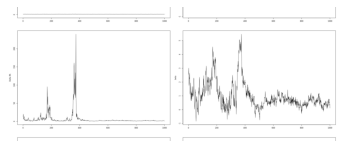

In [36]:
import matplotlib.image as mpimg

img = mpimg.imread("ZIDM50/32898/plots/cov1Traceplots.png")
plt.imshow(img)
plt.axis('off')  # Hide axes for cleaner display
x_min, x_max = 0, 1500  # For example, zoom from x-coordinate 50 to 200
y_min, y_max = 1000, 400  # And y-coordinate 100 to 300
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

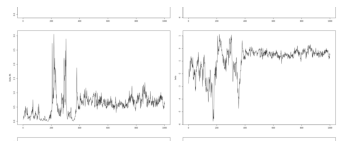

In [37]:
import matplotlib.image as mpimg

img = mpimg.imread("ZIDM50/32898/plots/cov3Traceplots.png")
plt.imshow(img)
plt.axis('off')  # Hide axes for cleaner display
x_min, x_max = 0, 1500  # For example, zoom from x-coordinate 50 to 200
y_min, y_max = 1000, 400  # And y-coordinate 100 to 300
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [38]:
# 58697 just had large intervals around a mean while 32898 showed signs of converging at a later point
# We drop 32898 since it wasnt converged. The above imgs show the non-convergence
wasNotConvergedOverSamplePeriod = ['32898']
toKeep = RAData.index.levels[1].difference(wasNotConvergedOverSamplePeriod)
RAData = RAData.loc[(slice(None), toKeep), :]

In [39]:
RADataIntercept = RAData[RAData["covariate"] == "intercept"]
RADataCov = RAData[RAData["covariate"] != "intercept"]

In [40]:
RAEval = getResults(RADataCov, RAEval, "RA 95 CI", "ZIDM Covariates")
RAEval = getResults(RADataIntercept, RAEval, "RA 95 CI", "ZIDM Intercepts")
BEval = getResults(RADataCov, BEval, "B(t) 95 CI", "ZIDM Covariates")
BEval = getResults(RADataIntercept, BEval, "B(t) 95 CI", "ZIDM Intercepts")
RMSEEval = getResults(RADataCov, RMSEEval, "mean RMSE", "ZIDM Covariates")
RMSEEval = getResults(RADataIntercept, RMSEEval, "mean RMSE", "ZIDM Intercepts")
toAdd = pd.DataFrame(indRACaptRates.mean()).T
toAdd.index = ["ZIDM"]
IndRAEval = pd.concat([IndRAEval, toAdd])

In [41]:
plotDat = RADataCov.loc[[1,2,3,4], ["zero prop"]+metrics].sort_values("zero prop")
x_ZIDM = plotDat["zero prop"]
y_ZIDM = plotDat[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)

## Multiple Covariates Results

In [42]:
RMSEEval

,Mean mean RMSE Cat 1-4,Median mean RMSE Cat 1-4,Mean mean RMSE Cat 5-50,Median mean RMSE Cat 5-50
Covariates,0.190273,0.158457,0.046149,0.038388
Intercepts,0.007301,0.006081,0.007238,0.005944
DM Covariates,0.257854,0.226022,0.036893,0.031913
DM Intercepts,0.011481,0.009996,0.012344,0.010712
FunCDM Covariates,0.195045,0.157742,0.032615,0.029686
FunCDM Intercepts,0.012080,0.009861,0.013038,0.010549
ZIDM Covariates,0.272900,0.197679,0.037328,0.032564
ZIDM Intercepts,0.008188,0.006441,0.007282,0.006143


In [43]:
latex = RMSEEval[["Mean mean RMSE Cat 1-4", "Mean mean RMSE Cat 5-50"]]
keep = ["Cov" in ind for ind in latex.index]
latex = latex[keep]
latex.index = ["FunC-ZIDM", "DM", "FunC-DM", "ZIDM"]
latex.index.names = ["Model"]
latex.columns = ["ARMSE Cat 1-4", "ARMSE Cat 5-50"]

In [44]:
BEval

,Mean B(t) 95 CI Cat 1-4,Median B(t) 95 CI Cat 1-4,Mean B(t) 95 CI Cat 5-50,Median B(t) 95 CI Cat 5-50
Covariates,0.934773,1.00,0.998702,1.0
Intercepts,0.964200,1.00,0.982763,1.0
DM Covariates,0.609875,0.63,0.998284,1.0
DM Intercepts,0.009675,0.00,0.005046,0.0
FunCDM Covariates,0.764918,0.90,0.999269,1.0
FunCDM Intercepts,0.309275,0.00,0.290539,0.0
ZIDM Covariates,0.869013,1.00,0.999785,1.0
ZIDM Intercepts,0.131317,0.04,0.087394,0.0


In [45]:
latex["B95 Cat 1-4"] = BEval["Mean B(t) 95 CI Cat 1-4"][keep].values
latex["B95 Cat 5-50"] = BEval["Mean B(t) 95 CI Cat 5-50"][keep].values

In [46]:
RAEval

,Mean RA 95 CI Cat 1-4,Median RA 95 CI Cat 1-4,Mean RA 95 CI Cat 5-50,Median RA 95 CI Cat 5-50
Covariates,0.935615,1.000,0.998061,1.00
Intercepts,0.968750,1.000,0.985959,1.00
DM Covariates,0.607600,0.620,0.981117,1.00
DM Intercepts,0.181350,0.000,0.121285,0.00
FunCDM Covariates,0.766270,0.900,0.983627,1.00
FunCDM Intercepts,0.330550,0.040,0.255148,0.00
ZIDM Covariates,0.869677,1.000,0.994935,1.00
ZIDM Intercepts,0.572769,0.595,0.412805,0.36


In [47]:
latex["RA95 Cat 1-4"] = RAEval["Mean RA 95 CI Cat 1-4"][keep].values
latex["RA95 Cat 5-50"] = RAEval["Mean RA 95 CI Cat 5-50"][keep].values

In [48]:
latex["MeAD"] = IndRAEval["MeAD"].values
latex["MeAD"] = IndRAEval["MeAD"].values

In [49]:
latex.columns

Index(['ARMSE Cat 1-4', 'ARMSE Cat 5-50', 'B95 Cat 1-4', 'B95 Cat 5-50',
       'RA95 Cat 1-4', 'RA95 Cat 5-50', 'MeAD'],
      dtype='object')

In [50]:
latex = latex[['MeAD', 'RA95 Cat 1-4', 'B95 Cat 1-4', 'ARMSE Cat 1-4', 
               'RA95 Cat 5-50', 'B95 Cat 5-50', 'ARMSE Cat 5-50']]
latex.columns =  pd.MultiIndex.from_tuples([('', 'MAD')] + pd.MultiIndex.from_product([["Categories 1-4", "Categories 5-50"],
                                                                                       ['RA95', 'B95', 'ARMSE']], 
                                                                                      names=["Category", "Type"]).tolist(),
                                           names=['Category', 'Type'])
latex

Category             Categories 1-4                     Categories 5-50  \
Type             MAD           RA95       B95     ARMSE            RA95   
Model                                                                     
FunC-ZIDM   8.375116       0.935615  0.934773  0.190273        0.998061   
DM         29.591712       0.607600  0.609875  0.257854        0.981117   
FunC-DM    27.214312       0.766270  0.764918  0.195045        0.983627   
ZIDM       27.684973       0.869677  0.869013  0.272900        0.994935   

Category                       
Type            B95     ARMSE  
Model                          
FunC-ZIDM  0.998702  0.046149  
DM         0.998284  0.036893  
FunC-DM    0.999269  0.032615  
ZIDM       0.999785  0.037328

In [51]:
print(latex.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrrrr}
\toprule
Category & \multicolumn{3}{l}{Categories 1-4} & \multicolumn{3}{l}{Categories 5-50} \\
Type &     MAD &           RA95 &    B95 &  ARMSE &            RA95 &    B95 &  ARMSE \\
Model     &         &                &        &        &                 &        &        \\
\midrule
FunC-ZIDM &  8.3751 &         0.9356 & 0.9348 & 0.1903 &          0.9981 & 0.9987 & 0.0461 \\
DM        & 29.5917 &         0.6076 & 0.6099 & 0.2579 &          0.9811 & 0.9983 & 0.0369 \\
FunC-DM   & 27.2143 &         0.7663 & 0.7649 & 0.1950 &          0.9836 & 0.9993 & 0.0326 \\
ZIDM      & 27.6850 &         0.8697 & 0.8690 & 0.2729 &          0.9949 & 0.9998 & 0.0373 \\
\bottomrule
\end{tabular}



In [52]:
%%bash
module load texlive

In [53]:
# Adding latex path so accessable by python
os.environ["PATH"] = "/curc/sw/texlive/2021/bin/x86_64-linux" + ":" + os.environ["PATH"]

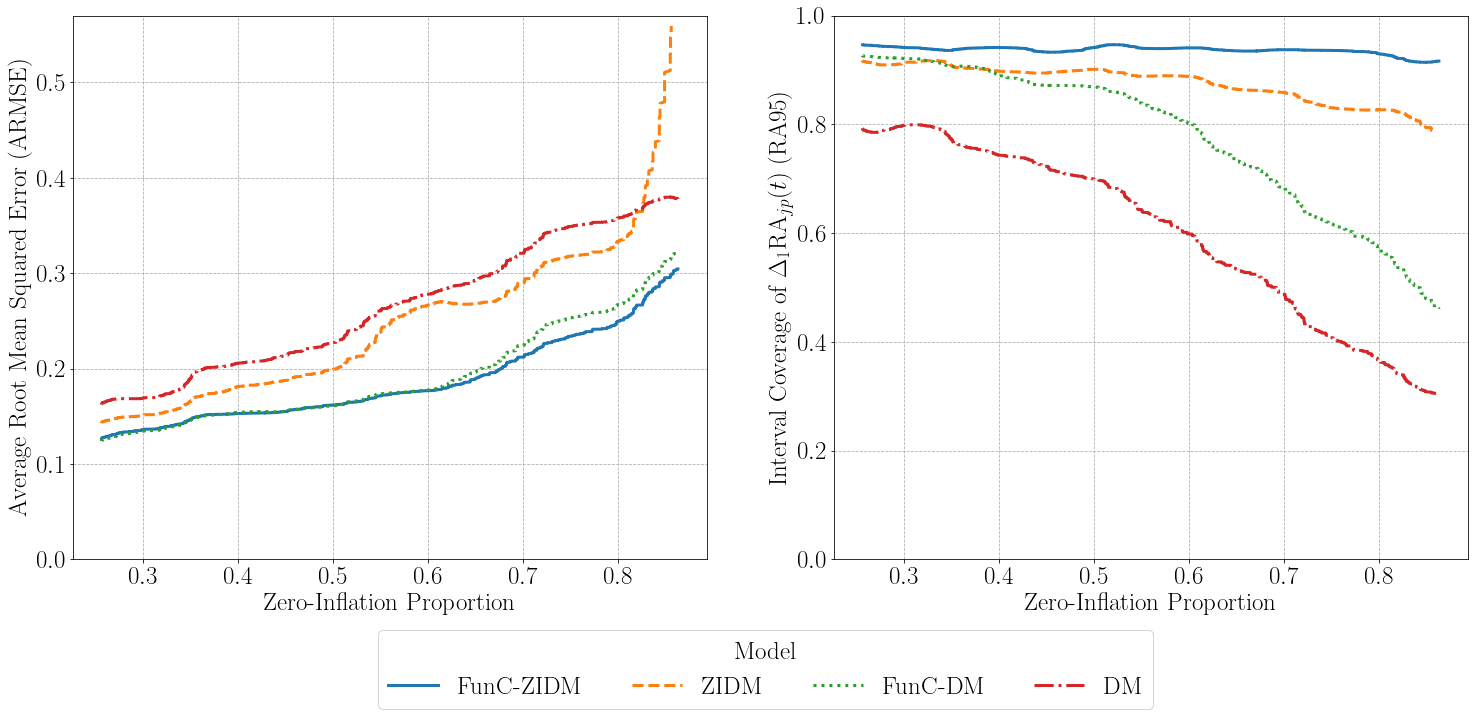

In [54]:
# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, axes = plt.subplots(1, 2, figsize=(25, 10))
axes = axes.flatten() 
fontsize = 25
 
axes[0].plot(x, y["mean RMSE"], label="FunC-ZIDM", linestyle="-", linewidth=3) 
axes[0].plot(x_ZIDM, y_ZIDM["mean RMSE"], label="ZIDM", linestyle="--", linewidth=3)
axes[0].plot(x_FunCDM, y_FunCDM["mean RMSE"], label="FunC-DM", linestyle=":", linewidth=3)
axes[0].plot(x_DM, y_DM["mean RMSE"], label="DM", linestyle="-.", linewidth=3)
axes[0].set_xlabel("Zero-Inflation Proportion", fontsize=fontsize)  
axes[0].set_ylabel("Average Root Mean Squared Error (ARMSE)", fontsize=fontsize)
axes[0].set_ylim([0, .57]) # ZIDM max is ~.56
axes[0].tick_params(labelsize=fontsize)
axes[0].grid(linestyle='--')

axes[1].plot(x, y["RA 95 CI"], label="FunC-ZIDM", linestyle="-", linewidth=3) 
axes[1].plot(x_ZIDM, y_ZIDM["RA 95 CI"], label="ZIDM", linestyle="--", linewidth=3)
axes[1].plot(x_FunCDM, y_FunCDM["RA 95 CI"], label="FunC-DM", linestyle=":", linewidth=3)
axes[1].plot(x_DM, y_DM["RA 95 CI"], label="DM", linestyle="-.", linewidth=3)
axes[1].set_xlabel("Zero-Inflation Proportion", fontsize=fontsize)  
axes[1].set_ylabel("Interval Coverage of $\Delta_1$RA$_{jp}(t)$ (RA95)", fontsize=fontsize)
axes[1].set_ylim([0, 1])
axes[1].tick_params(labelsize=fontsize)
axes[1].grid(linestyle='--')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Model", loc="lower center", bbox_to_anchor=(0.51, -0.1), ncol=5, fontsize=fontsize, title_fontsize=fontsize)
plt.savefig("RA95andARMSEMovingAve.png", bbox_inches="tight")

## Scalibility

In [55]:
def readInData(root, totalCoeffPerSeed = 550):
    # Get all the folders in the root and drop the code folders
    directories = [s for s in os.listdir(root) if os.path.isdir(root+s)]

    # Initating the dataframe, some folders may not have RAStats<seed>.csv due to memory or time-out
    dataInitated = False
    startIdx = 0
    while not dataInitated:
        dataInitated = True
        try:
            RAData = pd.read_csv(os.path.join(root, directories[startIdx], "RAStats"+directories[startIdx]+".csv"), usecols=range(8))
            if directories[startIdx] == "92608":
                print(RAData)
            RAData['seed'] = directories[startIdx]
            if RAData.shape[0] < totalCoeffPerSeed:
                print(directories[startIdx], "processed", RAData.shape[0], "coefficients")
                getReason(directories[startIdx])
        except:
            print(directories[startIdx], " did not have RA stats")
            dataInitated = False
        startIdx += 1

    # Appending all the rest of the RAStats<seed>.csv to the initial RAStats<seed>.csv
    for i in range(startIdx, len(directories)):
        try:
            toAppend = pd.read_csv(os.path.join(root, directories[i], "RAStats"+directories[i]+".csv"), usecols=range(8))
            toAppend['seed'] = directories[i]
            if toAppend.shape[0] < totalCoeffPerSeed:
                print(directories[i], "processed", toAppend.shape[0], "coefficients")
                getReason(directories[i], root) 
            if toAppend.shape[0] != 0:
                RAData = pd.concat([RAData, toAppend])
        except:
            print(directories[i], " did not have RA stats: ", end="")
            getReason(directories[i], root)
    
    RAData = RAData.set_index(['category','seed'])
     
    return RAData

### Small

- $N = 50$
- $J = 50$

In [56]:
root = "FunCZIDM50/"
directories = [s for s in os.listdir(root) if os.path.isdir(root+s)]

#### Evaluation of the sampling

In [57]:
evalData = pd.read_csv(os.path.join(root, directories[0], "eval"+directories[0]+".csv"))
evalData['seed'] = directories[0]

for i in range(1, len(directories)):
    toAppend = pd.read_csv(os.path.join(root, directories[i], "eval"+directories[i]+".csv"))
    toAppend['seed'] = directories[i]
    evalData = pd.concat([evalData, toAppend])

evalData = evalData.set_index(['metric','seed'])

In [58]:
toAdd = evalData.loc["2.5% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]
toAdd = pd.concat([toAdd, evalData.loc["50% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]], ignore_index=True)
toAdd = pd.concat([toAdd, evalData.loc["97.5% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]], ignore_index=True)
toAdd.loc[6] = evalData.loc["Proportion of zero indicators"].describe().loc["mean"]
toAdd.loc[7] = evalData.loc["True proportion zero inflated"].describe().loc["mean"]
toAdd.loc[8] = evalData.loc["Total time"].div(60).describe().loc["mean"]
SampEval = toAdd.T
SampEval.columns = ["Mean 2.5% quantile beta AR", "Median 2.5% quantile beta AR", "Mean 50% quantile beta AR", "Median 50% quantile beta AR",
                   "Mean 97.5% quantile beta AR", "Median 97.5% quantile beta AR", "Mean Proportion of ZI Indicators", "Mean True Proportion of ZI",
                   "Mean Total Time (min)"]
SampEval.index = ["50"]
SampEval.index.name = "J"
SampEval

,Mean 2.5% quantile beta AR,Median 2.5% quantile beta AR,Mean 50% quantile beta AR,Median 50% quantile beta AR,Mean 97.5% quantile beta AR,Median 97.5% quantile beta AR,Mean Proportion of ZI Indicators,Mean True Proportion of ZI,Mean Total Time (min)
J,,,,,,,,,
50,0.130198,0.133435,0.292617,0.29185,0.608399,0.614047,0.408583,0.409166,7.909395


#### Evaluation of the fit

In [59]:
RAData = readInData(root, totalCoeffPerSeed = 550)

In [60]:
RAData.columns = RAData.columns.str.strip()

In [61]:
RADataInter = RAData[RAData['covariate'] == 'intercept'].sort_index(sort_remaining=False)
RADataCov = RAData[RAData['covariate'] != 'intercept'].sort_index(sort_remaining=False)

In [62]:
RAEval = getResults(RADataCov, None, "RA 95 CI", "50/coef")
BetaEval = getResults(RADataCov, None, "B(t) 95 CI", "50/coef")
RMSEEval = getResults(RADataCov, None, "mean RMSE", "50/coef")
RAEval = getResults(RADataInter, RAEval, "RA 95 CI", "50/inter")
BetaEval = getResults(RADataInter, BetaEval, "B(t) 95 CI", "50/inter")
RMSEEval = getResults(RADataInter, RMSEEval, "mean RMSE", "50/inter")

In [63]:
metrics = ["B(t) 95 CI", "mean RMSE", "RA 95 CI"]
plotDat50 = RADataCov.loc[[1,2,3,4], ["zero prop"]+metrics].sort_values("zero prop")

### Medium

- $N = 50$
- $J = 250$

In [64]:
root = "FunCZIDM250/"
directories = [s for s in os.listdir(root) if os.path.isdir(root+s)]

#### Evaluation of the sampling

In [65]:
evalData = pd.read_csv(os.path.join(root, directories[0], "eval"+directories[0]+".csv"))
evalData['seed'] = directories[0]

for i in range(1, len(directories)):
    toAppend = pd.read_csv(os.path.join(root, directories[i], "eval"+directories[i]+".csv"))
    toAppend['seed'] = directories[i]
    evalData = pd.concat([evalData, toAppend])

evalData = evalData.set_index(['metric','seed'])

In [66]:
toAdd = evalData.loc["2.5% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]
toAdd = pd.concat([toAdd, evalData.loc["50% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]], ignore_index=True)
toAdd = pd.concat([toAdd, evalData.loc["97.5% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]], ignore_index=True)
toAdd.loc[6] = evalData.loc["Proportion of zero indicators"].describe().loc["mean"]
toAdd.loc[7] = evalData.loc["True proportion zero inflated"].describe().loc["mean"]
toAdd.loc[8] = evalData.loc["Total time"].div(60).describe().loc["mean"]
toAdd = toAdd.T
toAdd.columns = ["Mean 2.5% quantile beta AR", "Median 2.5% quantile beta AR", "Mean 50% quantile beta AR", "Median 50% quantile beta AR",
                   "Mean 97.5% quantile beta AR", "Median 97.5% quantile beta AR", "Mean Proportion of ZI Indicators", "Mean True Proportion of ZI",
                   "Mean Total Time (min)"]
toAdd.index = ["250"]
SampEval = pd.concat([SampEval, toAdd])

#### Evaluation of the fit

In [67]:
RAData = readInData(root, totalCoeffPerSeed = 2750)

In [68]:
RAData.columns = RAData.columns.str.strip()

In [69]:
toDrop = np.unique(RAData[RAData["mean RMSE"] > 1e+02].index.get_level_values(1))
toKeep = RAData.index.levels[1].difference(toDrop)
RAData = RAData.loc[(slice(None), toKeep), :]

In [70]:
RADataInter = RAData[RAData['covariate'] == 'intercept'].sort_index(sort_remaining=False)
RADataCov = RAData[RAData['covariate'] != 'intercept'].sort_index(sort_remaining=False)

In [71]:
toDrop

array([], dtype=object)

In [72]:
RAEval = getResults(RADataCov, RAEval, "RA 95 CI", "250/coef")
BetaEval = getResults(RADataCov, BetaEval, "B(t) 95 CI", "250/coef")
RMSEEval = getResults(RADataCov, RMSEEval, "mean RMSE", "250/coef")
RAEval = getResults(RADataInter, RAEval, "RA 95 CI", "250/inter")
BetaEval = getResults(RADataInter, BetaEval, "B(t) 95 CI", "250/inter")
RMSEEval = getResults(RADataInter, RMSEEval, "mean RMSE", "250/inter")

In [73]:
metrics = ["B(t) 95 CI", "mean RMSE", "RA 95 CI"]
plotDat250 = RADataCov.loc[[1,2,3,4], ["zero prop"]+metrics].sort_values("zero prop")

### Large

- $N = 50$
- $J = 500$

In [74]:
root = "FunCZIDM500/"
directories = [s for s in os.listdir(root) if os.path.isdir(root+s)]

#### Evaluation of the sampling

In [75]:
evalData = pd.read_csv(os.path.join(root, directories[0], "eval"+directories[0]+".csv"))
evalData['seed'] = directories[0]

for i in range(1, len(directories)):
    toAppend = pd.read_csv(os.path.join(root, directories[i], "eval"+directories[i]+".csv"))
    toAppend['seed'] = directories[i]
    evalData = pd.concat([evalData, toAppend])

evalData = evalData.set_index(['metric','seed'])

In [76]:
toAdd = evalData.loc["2.5% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]
toAdd = pd.concat([toAdd, evalData.loc["50% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]], ignore_index=True)
toAdd = pd.concat([toAdd, evalData.loc["97.5% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]], ignore_index=True)
toAdd.loc[6] = evalData.loc["Proportion of zero indicators"].describe().loc["mean"]
toAdd.loc[7] = evalData.loc["True proportion zero inflated"].describe().loc["mean"]
toAdd.loc[8] = evalData.loc["Total time"].div(60).describe().loc["mean"]
toAdd = toAdd.T
toAdd.columns = ["Mean 2.5% quantile beta AR", "Median 2.5% quantile beta AR", "Mean 50% quantile beta AR", "Median 50% quantile beta AR",
                   "Mean 97.5% quantile beta AR", "Median 97.5% quantile beta AR", "Mean Proportion of ZI Indicators", "Mean True Proportion of ZI",
                   "Mean Total Time (min)"]
toAdd.index = ["500"]
SampEval = pd.concat([SampEval, toAdd])

#### Evaluation of the fit

In [77]:
RAData = readInData(root, totalCoeffPerSeed = 5500)

In [78]:
RAData.columns = RAData.columns.str.strip()

In [79]:
toDrop = np.unique(RAData[RAData["mean RMSE"] > 1e+02].index.get_level_values(1))
toKeep = RAData.index.levels[1].difference(toDrop)
RAData = RAData.loc[(slice(None), toKeep), :]

In [80]:
toDrop

array([], dtype=object)

In [81]:
RADataInter = RAData[RAData['covariate'] == 'intercept'].sort_index(sort_remaining=False)
RADataCov = RAData[RAData['covariate'] != 'intercept'].sort_index(sort_remaining=False)

In [82]:
RAEval = getResults(RADataCov, RAEval, "RA 95 CI", "500/coef")
BetaEval = getResults(RADataCov, BetaEval, "B(t) 95 CI", "500/coef")
RMSEEval = getResults(RADataCov, RMSEEval, "mean RMSE", "500/coef")
RAEval = getResults(RADataInter, RAEval, "RA 95 CI", "500/inter")
BetaEval = getResults(RADataInter, BetaEval, "B(t) 95 CI", "500/inter")
RMSEEval = getResults(RADataInter, RMSEEval, "mean RMSE", "500/inter")

In [83]:
metrics = ["B(t) 95 CI", "mean RMSE", "RA 95 CI"]
plotDat500 = RADataCov.loc[[1,2,3,4], ["zero prop"]+metrics].sort_values("zero prop")

### Extra Large

- $N = 50$
- $J = 1000$

In [84]:
root = "FunCZIDM1000/"
directories = [s for s in os.listdir(root) if os.path.isdir(root+s)]

#### Evaluation of the sampling

In [85]:
evalData = pd.read_csv(os.path.join(root, directories[0], "eval"+directories[0]+".csv"))
evalData['seed'] = directories[0]

for i in range(1, len(directories)):
    toAppend = pd.read_csv(os.path.join(root, directories[i], "eval"+directories[i]+".csv"))
    toAppend['seed'] = directories[i]
    evalData = pd.concat([evalData, toAppend])

evalData = evalData.set_index(['metric','seed'])

In [86]:
toAdd = evalData.loc["2.5% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]
toAdd = pd.concat([toAdd, evalData.loc["50% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]], ignore_index=True)
toAdd = pd.concat([toAdd, evalData.loc["97.5% acceptance rate quantile for beta"].describe().loc[["mean", "50%"]]], ignore_index=True)
toAdd.loc[6] = evalData.loc["Proportion of zero indicators"].describe().loc["mean"]
toAdd.loc[7] = evalData.loc["True proportion zero inflated"].describe().loc["mean"]
toAdd.loc[8] = evalData.loc["Total time"].div(60).describe().loc["mean"]
toAdd = toAdd.T
toAdd.columns = ["Mean 2.5% quantile beta AR", "Median 2.5% quantile beta AR", "Mean 50% quantile beta AR", "Median 50% quantile beta AR",
                   "Mean 97.5% quantile beta AR", "Median 97.5% quantile beta AR", "Mean Proportion of ZI Indicators", "Mean True Proportion of ZI",
                   "Mean Total Time (min)"]
toAdd.index = ["1000"]
SampEval = pd.concat([SampEval, toAdd])

#### Evaluation of the fit

In [87]:
RAData = readInData(root, totalCoeffPerSeed = 11000)

In [88]:
RAData.columns = RAData.columns.str.strip()

In [89]:
toDrop = np.unique(RAData[RAData["mean RMSE"] > 1e+02].index.get_level_values(1))
toKeep = RAData.index.levels[1].difference(toDrop)
RAData = RAData.loc[(slice(None), toKeep), :]

In [90]:
toDrop

array([], dtype=object)

In [91]:
RADataInter = RAData[RAData['covariate'] == 'intercept'].sort_index(sort_remaining=False)
RADataCov = RAData[RAData['covariate'] != 'intercept'].sort_index(sort_remaining=False)

In [92]:
RAEval = getResults(RADataCov, RAEval, "RA 95 CI", "1000/coef")
BetaEval = getResults(RADataCov, BetaEval, "B(t) 95 CI", "1000/coef")
RMSEEval = getResults(RADataCov, RMSEEval, "mean RMSE", "1000/coef")
RAEval = getResults(RADataInter, RAEval, "RA 95 CI", "1000/inter")
BetaEval = getResults(RADataInter, BetaEval, "B(t) 95 CI", "1000/inter")
RMSEEval = getResults(RADataInter, RMSEEval, "mean RMSE", "1000/inter")

In [93]:
metrics = ["B(t) 95 CI", "mean RMSE", "RA 95 CI"]
plotDat1000 = RADataCov.loc[[1,2,3,4], ["zero prop"]+metrics].sort_values("zero prop")

## Scalability Results

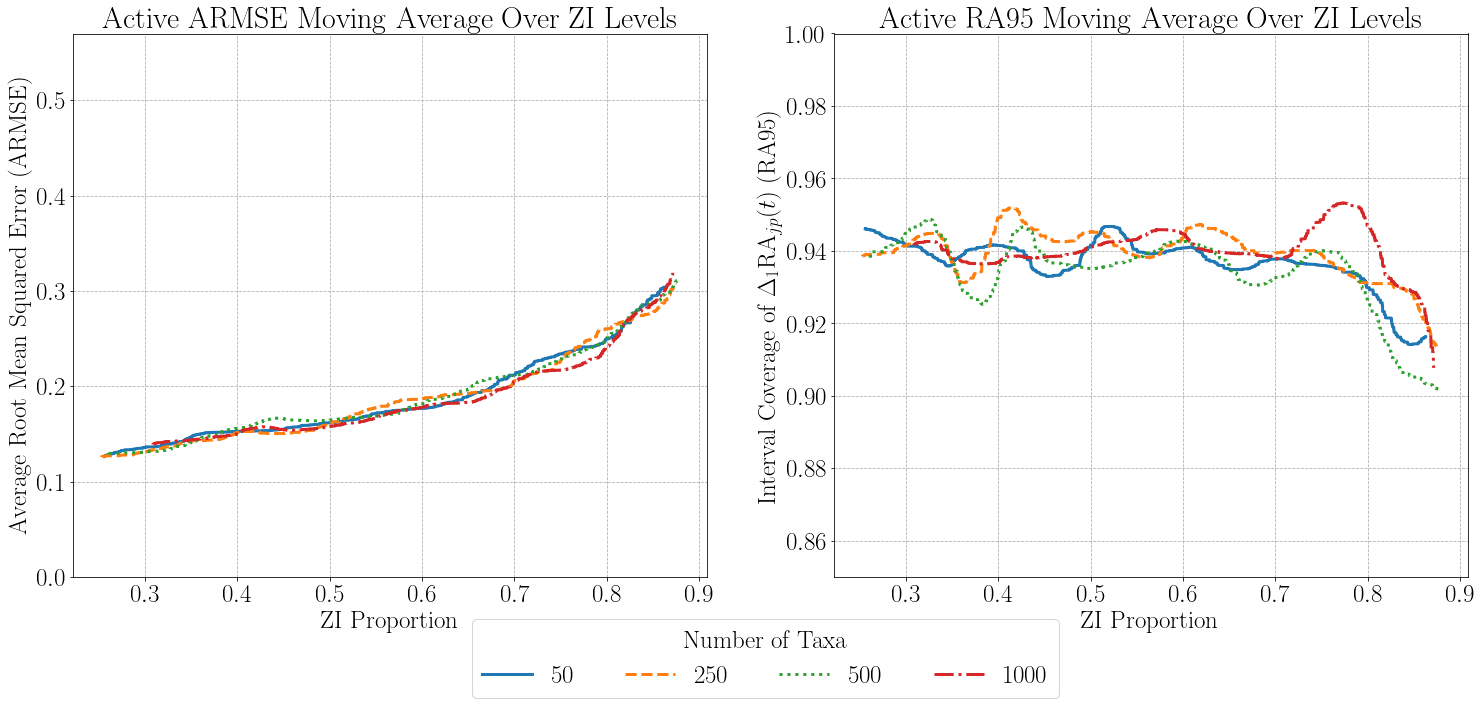

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
axes = axes.flatten() 

window = 750
std = (window - 1)/6
fontsize = 25

x = plotDat50["zero prop"]
y = plotDat50[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)
axes[0].plot(x, y["mean RMSE"], label="50", linestyle="-", linewidth=3) 
x = plotDat250["zero prop"]
y = plotDat250[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)
axes[0].plot(x, y["mean RMSE"], label="250", linestyle="--", linewidth=3) 
x = plotDat500["zero prop"]
y = plotDat500[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)
axes[0].plot(x, y["mean RMSE"], label="500", linestyle=":", linewidth=3) 
x = plotDat1000["zero prop"]
y = plotDat1000[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)
axes[0].plot(x, y["mean RMSE"], label="1000", linestyle="-.", linewidth=3) 
axes[0].set_title("Active ARMSE Moving Average Over ZI Levels", fontsize=30) 
axes[0].set_xlabel("ZI Proportion", fontsize=fontsize)  
axes[0].set_ylabel("Average Root Mean Squared Error (ARMSE)", fontsize=fontsize)
axes[0].set_ylim([0, .57]) # ZIDM max is ~.56, keeping the same for size reference
axes[0].tick_params(labelsize=fontsize)
axes[0].grid(linestyle='--')

x = plotDat50["zero prop"]
y = plotDat50[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)
axes[1].plot(x, y["RA 95 CI"], label="50", linestyle="-", linewidth=3) 
x = plotDat250["zero prop"]
y = plotDat250[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)
axes[1].plot(x, y["RA 95 CI"], label="250", linestyle="--", linewidth=3) 
x = plotDat500["zero prop"]
y = plotDat500[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)
axes[1].plot(x, y["RA 95 CI"], label="500", linestyle=":", linewidth=3) 
x = plotDat1000["zero prop"]
y = plotDat1000[metrics].rolling(window=window, win_type='gaussian', center=True).mean(std=std)
axes[1].plot(x, y["RA 95 CI"], label="1000", linestyle="-.", linewidth=3) 
axes[1].set_ylim([.85, 1])
axes[1].set_title("Active RA95 Moving Average Over ZI Levels", fontsize=30) 
axes[1].set_xlabel("ZI Proportion", fontsize=fontsize)  
axes[1].set_ylabel("Interval Coverage of $\Delta_1$RA$_{jp}(t)$ (RA95)", fontsize=fontsize)
axes[1].tick_params(labelsize=fontsize)
axes[1].grid(linestyle='--')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Number of Taxa", loc="lower center", bbox_to_anchor=(0.51, -0.06), ncol=5, fontsize=fontsize, title_fontsize=fontsize)
plt.savefig("RA95andARMSEMovingAveScalability.png", bbox_inches="tight")

In [95]:
RMSEEval

,Mean mean RMSE Cat 1-4,Median mean RMSE Cat 1-4,Mean mean RMSE Cat 5-50,Median mean RMSE Cat 5-50
50/coef,0.190273,0.158457,0.046149,0.038388
50/inter,0.007301,0.006081,0.007238,0.005944
250/coef,0.197093,0.163417,0.042816,0.034454
250/inter,0.001541,0.001227,0.001382,0.001108
500/coef,0.198268,0.161526,0.043176,0.034693
500/inter,0.000739,0.000604,0.000681,0.000551
1000/coef,0.201387,0.166970,0.043683,0.034776
1000/inter,0.000373,0.000312,0.000315,0.000257


In [96]:
BetaEval

,Mean B(t) 95 CI Cat 1-4,Median B(t) 95 CI Cat 1-4,Mean B(t) 95 CI Cat 5-50,Median B(t) 95 CI Cat 5-50
50/coef,0.934773,1.0,0.998702,1.0
50/inter,0.964200,1.0,0.982763,1.0
250/coef,0.936437,1.0,0.998716,1.0
250/inter,0.976925,1.0,0.981178,1.0
500/coef,0.932055,1.0,0.998627,1.0
500/inter,0.988200,1.0,0.979578,1.0
1000/coef,0.935682,1.0,0.998650,1.0
1000/inter,0.974400,1.0,0.973943,1.0


In [97]:
RAEval

,Mean RA 95 CI Cat 1-4,Median RA 95 CI Cat 1-4,Mean RA 95 CI Cat 5-50,Median RA 95 CI Cat 5-50
50/coef,0.935615,1.0,0.998061,1.0
50/inter,0.968750,1.0,0.985959,1.0
250/coef,0.936590,1.0,0.998551,1.0
250/inter,0.977600,1.0,0.979707,1.0
500/coef,0.932110,1.0,0.998529,1.0
500/inter,0.987275,1.0,0.978352,1.0
1000/coef,0.935437,1.0,0.998641,1.0
1000/inter,0.977125,1.0,0.972304,1.0
